<h1><center>Выбор локации для нефтеной скважины</center></h1>

## Введение

Описание проекта:
Заказ компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


Условия задачи:

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Алгоритм работы:
   1. Введение
   2. Обзор данных
   3. Поготовка данных
   4. Обучение моделей
   5. Подсчет максимальной прибыли для каждого региона
   6. Оценка рисков
   7. Общий вывод

Описание данных
Данные геологоразведки трёх регионов находятся в файлах:

    /datasets/geo_data_0.csv. Скачать датасет
    /datasets/geo_data_1.csv. Скачать датасет
    /datasets/geo_data_2.csv. Скачать датасет

    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек;
    product — объём запасов в скважине (тыс. баррелей).

## Обзор данных

Импортируем библиотеки

In [224]:
import urllib.request
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from os import path
from pathlib import Path
from sklearn.metrics import mean_squared_error


Загрузим и посмотрим датасет

In [225]:
YANDEX_DATASETS_PATH = 'https://code.s3.yandex.net/datasets/'
dataset_folder = 'datasets'
dataset_list = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']

#download dataset if not existed
for dataset_name in dataset_list:
    if not path.exists(dataset_folder + '/' + dataset_name):
        #create dir if not existed
        Path(dataset_folder).mkdir(parents=True, exist_ok=True)

        #download dataset
        urllib.request.urlretrieve(YANDEX_DATASETS_PATH + dataset_name,
                                   dataset_folder + '/' + dataset_name)

geo_0 = pd.read_csv(dataset_folder + '/' + dataset_list[0])
geo_1 = pd.read_csv(dataset_folder + '/' + dataset_list[1])
geo_2 = pd.read_csv(dataset_folder + '/' + dataset_list[2])
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [226]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [227]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<AxesSubplot:>

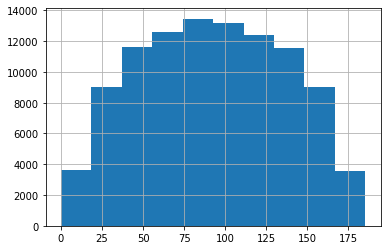

In [228]:
geo_0['product'].hist()

<AxesSubplot:>

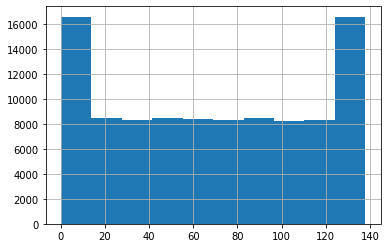

In [229]:
geo_1['product'].hist()

<AxesSubplot:>

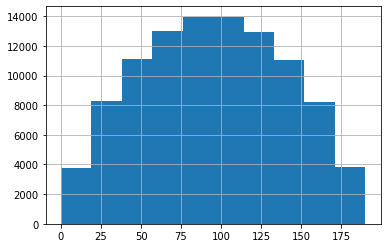

In [230]:
geo_2['product'].hist()

Вывод: распределение количества запасов в регонах 0 и 2 имеет форму нормального распределения.

## Подготовка данных

Создадим листы features и targets с исходными данными


In [231]:
X = []
y = []
geo = []

geo.extend([geo_0,
            geo_1,
            geo_2])

X.extend([geo_0[['f0', 'f1', 'f2']],
          geo_1[['f0', 'f1', 'f2']],
          geo_2[['f0', 'f1', 'f2']]])

y.extend([geo_0[['product']],
          geo_1[['product']],
          geo_2[['product']]])


Разделим данные на обучающую и валидационную выборки. Для этого напишем функцию разделения выборки. Функция возвращает словарь по каждой из выборок.
Например:


 df_data['train']['X'] - это features обучающей выборки


 df_data['valid']['y'] - это targets валидационной выборки

In [232]:
def split_train_valid_test(X, y, valid_test_size):

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_test_size, random_state=123)

    df_data = {'train': {'X': X_train, 'y': y_train},
               'valid': {'X': X_valid, 'y': y_valid}}

    return df_data

Разделим выборки:

In [233]:
data_geo = ['']*3

for i in range(3):
    data_geo[i] = split_train_valid_test(X[i], y[i], 0.25)

Вывод: разделили данные на тренировочный и валидационный сет в соотношение 3 к 1.

## Обучение моделей

Обучим модель линейной регрессии для каждой из выборок

In [234]:
model_geo = ['']*3

for i in range(3):
    model_geo[i] = LinearRegression().fit(data_geo[i]['train']['X'], data_geo[i]['train']['y'])


Сделаем предсказания, подсчитаем среднее и rmse

In [235]:
geo_predict = ['']*3
geo_rmse = ['']*3
geo_mean = ['']*3

for i in range(3):
    geo_predict[i] = model_geo[i].predict(data_geo[i]['valid']['X'])
    geo_rmse[i] = mean_squared_error(data_geo[i]['valid']['y'], geo_predict[i], squared=False)
    geo_mean[i] = geo_predict[i].mean()

Результаты занесем в таблицу

In [236]:
results = {'mean':[geo_mean[0], geo_mean[1], geo_mean[2]], 'rmse':[geo_rmse[0], geo_rmse[1], geo_rmse[2]]}
print(pd.DataFrame(results))

        mean       rmse
0  92.549362  37.647863
1  69.280019   0.895414
2  95.098599  40.128030


Вывод: наибольшое среднее значение предсказаний у региона номер "2". У него же наибольшее rmse. Наименьшее среднее у скважины номер "1". У нее же наименьшее rmse, почти равное нулю.

## Подсчет максимальной прибыли для каждого региона

Занесем бюджет(budget), доход с каждой единицы продукта(product_profit), количество скважин(n), вероятность убытков(probs) в соответствующие переменные

In [237]:
BUDGET = 10 * (10 ** 9)
PRODUCT_PROFIT = 450000
N = 200

Подсчитаем общее количество продукта(сырья в тыс. баррелей), необходимое для окупаемости

In [238]:
PRODUCT_VOLUME = BUDGET / PRODUCT_PROFIT
PRODUCT_VOLUME

22222.222222222223

Разделим его на количество разрабатываемых скважин и найдем среднее.

In [239]:
PRODUCT_MEAN = PRODUCT_VOLUME / N
PRODUCT_MEAN

111.11111111111111

Это среднее количество сырья в скважине, необходимое для окупаемости. Это значение больше, чем предсказанные средние для каждого региона

Сделаем функцию для расчёта прибыли по предсказаным данным

In [240]:
def predict_profit(df_values):
    geo_predict_best = df_values.sort_values(by='predict', ascending=False)[:200]
    geo_predict_profit = geo_predict_best['product'].sum() * PRODUCT_PROFIT
    return (geo_predict_profit - BUDGET) / 1000000000

Посчитаем прибыль для скаважин с максимальными значениями предсказаний для каждого региона. Результат округлен до млрд руб

In [241]:
geo_profit = ['']*3

for i in range(3):
    values = geo[i].loc[data_geo[i]['valid']['X'].index]
    values['predict'] = geo_predict[i]
    geo_profit[i] = predict_profit(values)
    print(geo_profit[i])

3.534670917261383
2.4150866966815108
2.3703438630213736


Вывод: для скважин с максимальными предсказанными запасами сырья наибольшая прибыль у региона 0. Наименьшая у региона "2"

## Оценка рисков

Оценим риски разработки скважин методом bootstrap. Для этого возьмем предсказанные значения и из них 1000 раз выберем 500 случайных скважин. Найдем прибыль для каждой из выборок, а затем найдем среднюю прибыль, доверительный интервал в 95% и шанс отрицательной прибыли.

In [242]:
bootstrap_samples = 1000
state = np.random.RandomState(12345)
profit_results = pd.DataFrame(columns=["mean", "lower", "upper", "negative_profit_prob"])

for k in range(3):
    sample_profit_list = []

    for i in range(bootstrap_samples):
        sample = data_geo[k]['valid']['X'].sample(frac=0.02, replace=False, random_state=state)
        sample_data = geo[k].loc[sample.index]
        sample_predict = model_geo[k].predict(sample)
        sample_data['predict'] = sample_predict
        sample_predict_profit = predict_profit(sample_data)
        sample_profit_list.append(sample_predict_profit)

    sample_profit_series = pd.Series(sample_profit_list)
    profit_mean = sample_profit_series.mean()
    lower = sample_profit_series.quantile(0.025)
    upper = sample_profit_series.quantile(0.975)
    negative_profit_prob = (sample_profit_series < 0).mean()
    series = pd.Series([profit_mean, lower, upper, negative_profit_prob], index=profit_results.columns)
    profit_results = profit_results.append(series, ignore_index=True)


Посмотрим результаты:

In [243]:
profit_results.head()

,mean,lower,upper,negative_profit_prob
0,0.489536,0.005488,0.975341,0.023
1,0.459929,0.078069,0.860812,0.010
2,0.337149,-0.198666,0.846866,0.101


Вывод: риски отрицальной прибыли ниже заявленных требований в 2.5% в 2-ух регионах: "0" и "1". Наибольшая средняя прибыль у региона 0.

## Общий Вывод

Мы провели исследование по выбору локации для бурения скважин. Целью работы было оценка рисков и расчет средней прибыли для каждого региона. Чтобы, впоследствии выбрать регион для разработки с наилучшими показателями. Мы разделили выборки на обучающую и валидационую. Построив модели линейной регрессии для каждого региона и посчитав риски методом bootstrap, мы получили следующие результаты:

- Регион 0: сред. прибыль 0.49 млрд руб. Риск убытков: 2.3%
- Регион 1: сред. прибыль 0.46 млрд руб. Риск убытков: 1.0%
- Регион 2: сред. прибыль 0.33 млрд руб. Риск убытков: 10.0%


По заявленной задаче риск убытков должен быть меньше 2.5%. Только регионы "0" и "1" показали значения меньшее этого. Самая высокая прогнозируемая средняя прибыль в регионе номер "0". Следовательно, это и есть регион рекомендуемый для разработки скважин.